In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from my_awesome_eda import run_eda

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("../data/raw_data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


Here is EDA for your dataframe ;)

Observations (rows): 17996
Parameters (features, columns): 17

Data types:
+--------------------+---------+-------------+
|                    |  dtype  |    type     |
+--------------------+---------+-------------+
| Artist Name        | object  |   string    |
| Track Name         | object  |   string    |
| Popularity         | float64 |  numerical  |
| danceability       | float64 |  numerical  |
| energy             | float64 |  numerical  |
| key                | float64 | categorical |
| loudness           | float64 |  numerical  |
| mode               |  int64  | categorical |
| speechiness        | float64 |  numerical  |
| acousticness       | float64 |  numerical  |
| instrumentalness   | float64 |  numerical  |
| liveness           | float64 |  numerical  |
| valence            | float64 |  numerical  |
| tempo              | float64 |  numerical  |
| duration_in min/ms | float64 |  numerical  |
| time_signature     |  int64  | categorical

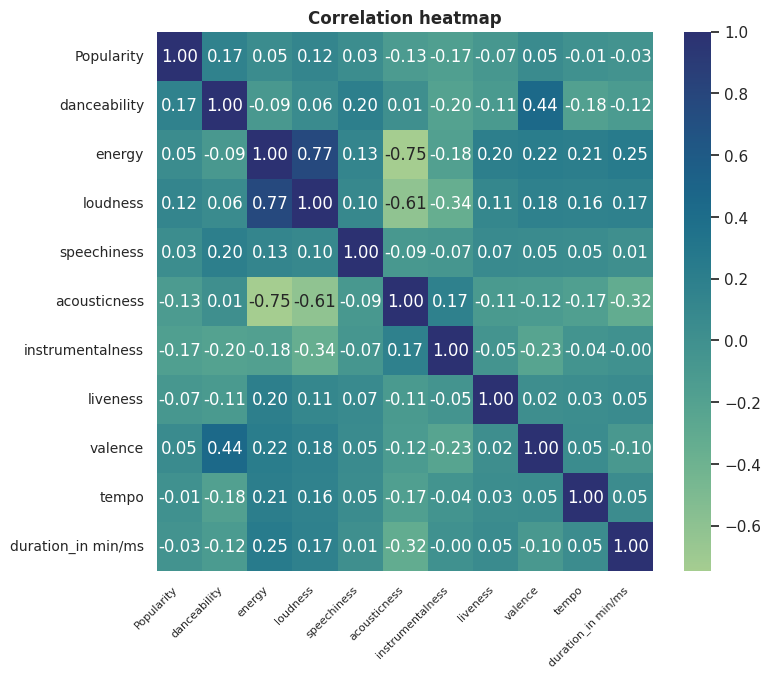


Outliers for numerical features:
------------------  ----
Popularity           469
danceability          31
energy                 0
loudness             818
speechiness         2034
acousticness           0
instrumentalness    6785
liveness             956
valence                0
tempo                 36
duration_in min/ms  3245
------------------  ----



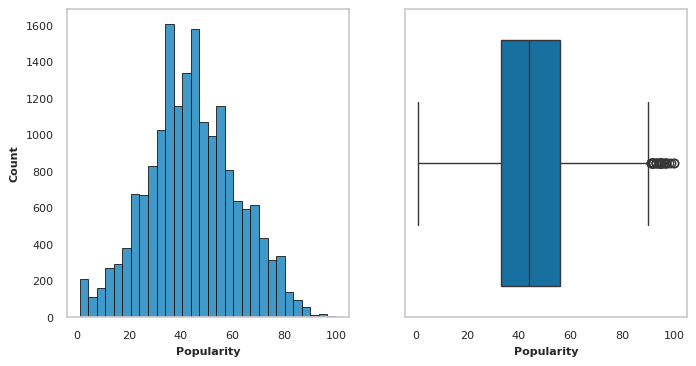

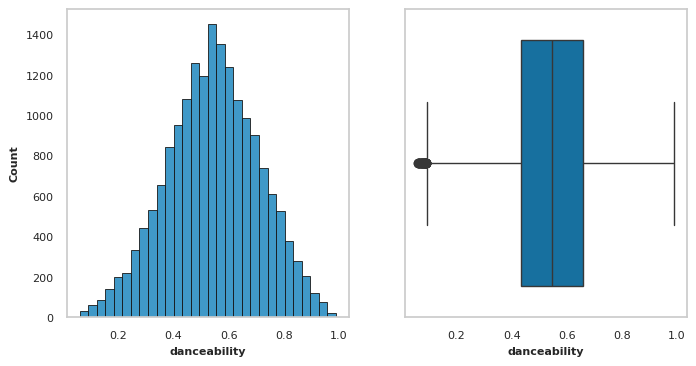

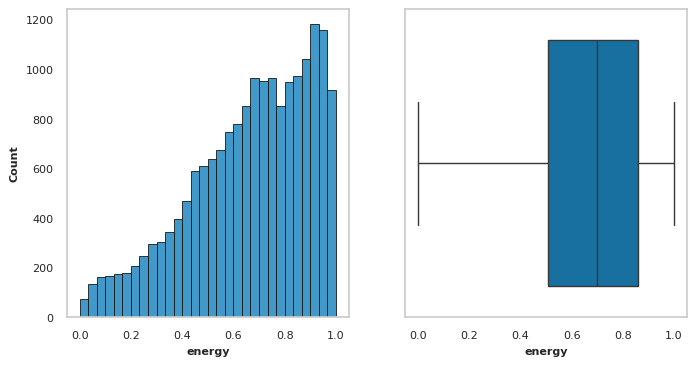

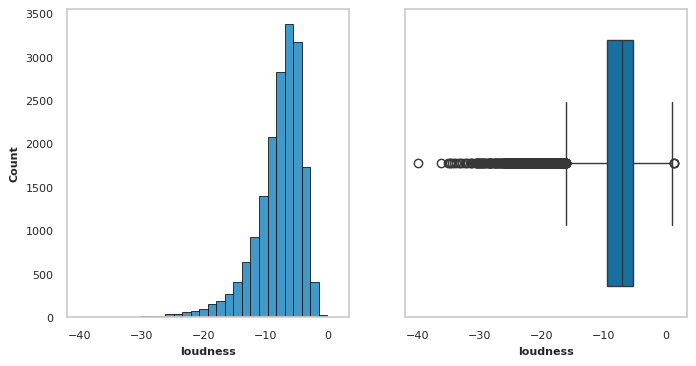

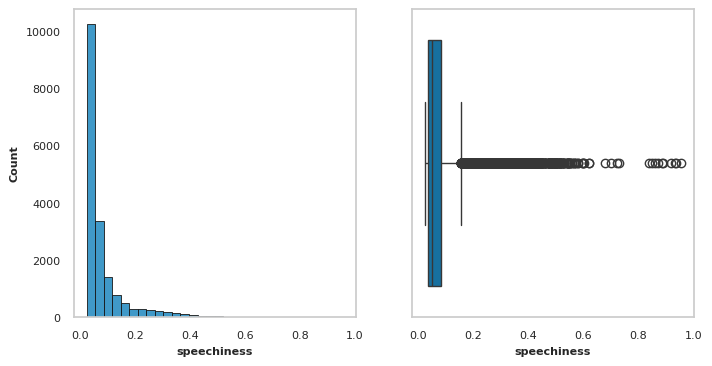

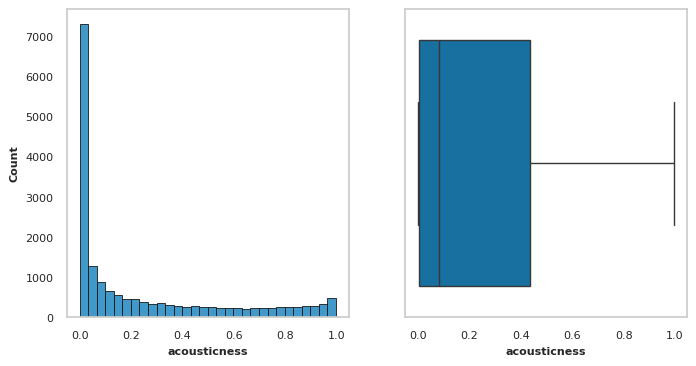

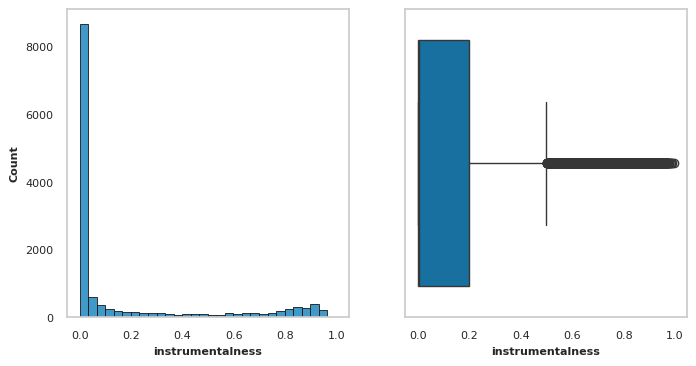

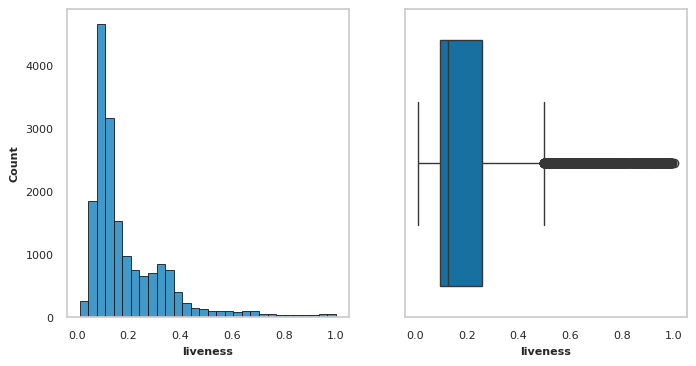

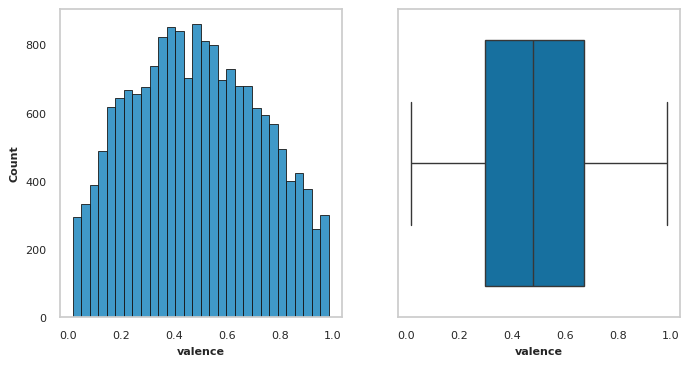

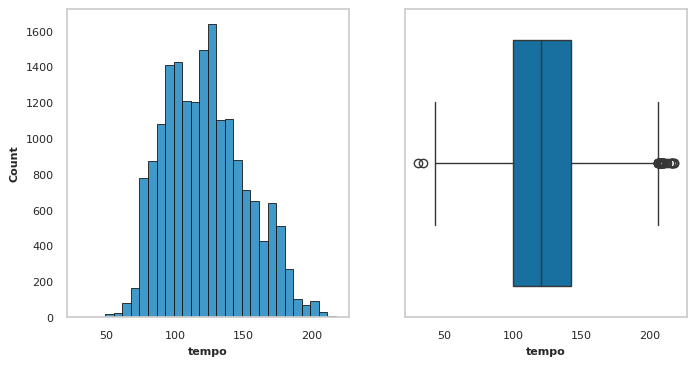

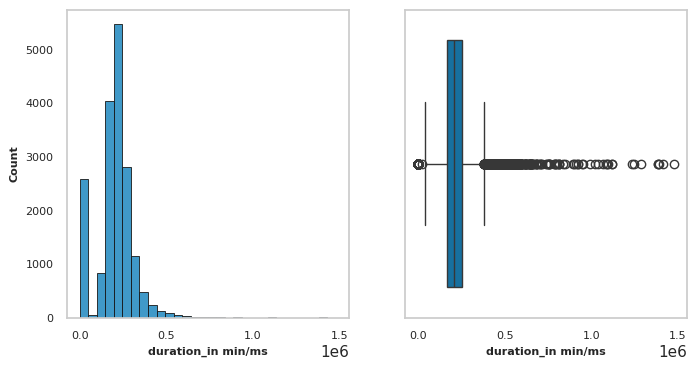


Missing values (NAs):
Total NA: 6819
Rows with NA: 6183
Columns with NA: ['Popularity' 'key' 'instrumentalness']



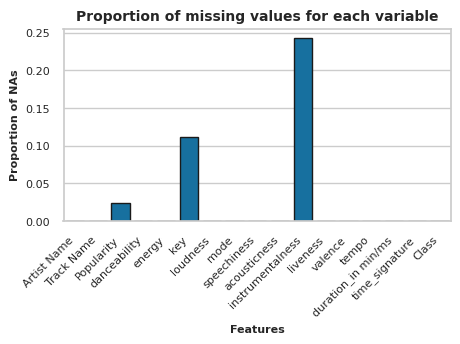


Number of duplicates (rows): 0


In [3]:
run_eda(data, category_threshold=12, correlation_figsize=(8, 7))

> Т.к. у нас всего **12 классов**, то я запустил EDA с таким же порогом для правильного определения категориальных колонок. По информации с kaggle, классы следующие: Rock, Indie, Alt, Pop, Metal, HipHop, Alt_Music, Blues, Acoustic/Folk, Instrumental, Country, Bollywood. Однако у нас их **<u>11</u>**, что немного странно

> 17996 наблюдений и 17 фич, большой датасет

> Получили такие строковые признаки:
- `Artist Name`: тут понятно, можем убирать
- `Track Name`: аналогично

> Получили следующие категориальные признаки:
- `key`: несмотря на то, что dtype float64, можно видеть, что всего 11 классов, и они даже более-менее сбалансированы, и при этом не совпадают с таргет-колонкой, а значит потенциально можент быть хорошей фичей для предсказания, довольно много пропущенных значений, конвертируем в category
- `mode`: бинарный признак, явно category
- `time_signature`: не очень понятно, что это, странная нумерация (1,3,4,5) и к тому же ужасный дисбаланс. Тем не менее, эти самые малочисленные категории могут быть хорошим предиктором для некоторых классов, тоже конвертирую в category
- `Class`: наш target, и снова явный дисбаланс классов, что очень плохо, тоже category

> Рассмотрим численные признаки и их описательные статистики:
- `Popularity`: значения в процентах от 0 до 100, есть пропущенные значения, распределение нормальное
- `danceability`: значения в процентах от 0 до 1, распределение нормальное
- `energy`: значения в процентах от 0 до 1, распределение ненормальное
- `loudness`: уже другой показатель, распределение смещено в сторону отрицательных значений
- `speechiness`: значения в процентах от 0 до 1, распределение ненормальное, больше всего значений ближе к 0
- `acousticness`: значения в процентах от 0 до 1, больше всего значений ближе к 0, в остальном более-менее равномерное
- `instrumentalness`: значения в процентах от 0 до 1, очень много пропущенных значений, больше всего значений ближе к 0, в остальном более-менее равномерное
- `liveness`: значения в процентах от 0 до 1, слабенькое бимодальное распределение, большинство значений в первой половине оси
- `valence`: значения в процентах от 0 до 1, распределение нормальное
- `tempo`: а этот признак явно не в процентах, распределение похоже на нормальное
- `duration_in min/ms`: минуты или миллисекунды, судя по распределению, большинство песен в миллисекундах, несмотря на это, для нас удобнее будет смотреть на минуты, поэтому конвертируем в минуты

> Корреляции (нам в целом это не очень важно, опять же, потому что лес):
- несильная прямая (0.44) valence-danceability
- обратная (-0.75) acousticness-energy
- обратная (-0.61) acousticness-loudness

> Выбросы: как будто очень много, но учитывая сильный дисбаланс классов, многие распределения просто смещены в сторону соответствующих классов, ну а в случае продолжительности просто разная запись, так что все оставляем и обрабатываем, как я описал ранее

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1.

2.

3.